## My current approach

I tried making a bigger and more ambitoius track at the school. However, my results were significantly worse there than home and running the results was not as convenient. I am not totally sure why but my guess is that the shiny floor and lighting conditions caused a lot of glare that might have confused the car. So I settled to run some results home to at least get some benchmark on the performance. For this I used a track modeled into a shape of figure 8.

<img src="track.jpg" width="500">

I chose this shape because it has both left and right turns and it is also symmetric. My thinking was that this way I could see that once the car made it through the first half, I could immediately see if it also generalized on the second half. To some extent this actually happened but generally not. The track seems simple but it is not that trivial for the car to navigate.

#### Currently my approach for this problem is:
- Input: Single grayscaled image that is cropped from the original 120x160px to 80x160px and resized to 40x40. Upper part of image is mostly surroundings which should not be necessary for the input. I have also tried RGB images and frame stacking but those did not seem to help. The image is fed through the encoder and the resulting embedding is then augmented with a history of 5 previous controls.
- Encoder: Two convolutional layers the first one with 16 and the second one with 32 channels and both with kernel size of 3x3. After these is a single fully connected layer with dimension of 32. I've tried using both a determinisctic and variational autoencoder but the variational seems to work better.
- SAC: I use two layer MLP networks with hidden size of 64.
- Training: The model is updated 600 times between each episode with a batch size of 128. Learning rate for the critic and actor is 1e-4 and for the encoder 1e-5.
- The critic optimizer also has the encoder parameters. This way when critic optimizer is stepped it also trains the encoder layers. After this the encoder is also updated with the VAE loss using another optimizer. However, this seems a bit schetchy way to do use critic loss for the encoder and I don't know if a proper way would somehow be to calculate a combined loss from the critic loss and encoder loss which would also enable to weight the losses differently for the encoder. Now that I think about it, the way I'm doing it now is probably wrong.

#### Experimental setup:
- The control loop is driven at 10Hz frequenzy. The car runs at 20Hz.
- Each run is started with 5 random episodes.
- Each episode is started from the same point.
- Episodes are terminated when the car drives off the track. This is essentially determined by counting black pixels in front of the car.
- Each step that the car drives on the track yields a reward of 1. When car drives off track it receives a penalty of -10.
- The run is continued until three consecutive episodes of maximum length of 500 steps which is about 3 laps. This does not necessarily mean that the algorithm has converged, and even after this it is still possible for the car to do something stupid. However, there is not much sense in driving around after this point if the point is not to test the stability of the solution.
- Throttle is fixed with the goal of maintaining a constant speed. This however is easier said and done and now that I've done more driving I've noticed many problems with this approach. In addition to the battery voltage, the relationship between the throttle and the speed of the car is also affected by the steering angle, temperature of the battery and individual charasteristics of the battery. <b>I think that it is essential in the future to get a way of measuring and controlling the speed of the car. This would benefit the model, the training workflow and most importantly give some concrete way of eveluating performance and results, since as it stands, I think the results are pretty arbitrary.</b> I think that the best option would be the RealSense camera, since it should give a solid way of measuring speed of the car conveniently. Also, if it has a reliable SLAM, it would be possible to map the track beforehand and use that as a way of automatically terminating the episode. This would also open up the possibility of using any track or even no track at all. In addition to more reliable termination signals this would also make it possible to use the distance from the track as a better reward.

In [43]:
import visualize
from importlib import reload

reload(visualize)

<module 'visualize' from '/home/ari/Documents/RLDonkeyCar/analysis/visualize.py'>

## Results

I made some quick plots on the results I have thus far. There is not that much data but it hopefully gives a clue on the current performance.


### Real car, no pretrained VAE

Run 1, Episodes: 69, Time: 39 minutes
Run 2, Episodes: 84, Time: 50 minutes
Run 3, Episodes: 94, Time: 58 minutes
Run 4, Episodes: 80, Time: 51 minutes


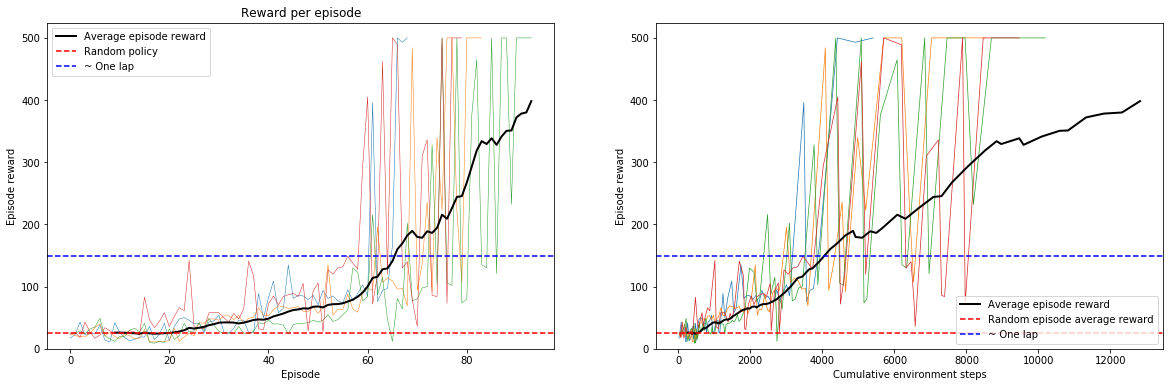

In [44]:
visualize.visualize_run("../records/real_not_pretrained_1/", real_car=True)

The car learns to drive after about 60 episodes or 4000 environment steps. However, the stability is dubious at best.

Here the run was ended when three consecutive episodes of 500 were reached. I probably should run some experiment for longer to see if the stability would converge. However, I think with this current experimental setup it is not possible to get this much more consistent. This is mainly because controlling the throttle is so challenging.

This solution does not generalize to driving the track in the opposite direction immediately and additional training is needed, but I haven't tested how much.

### Real car, pretrained VAE

Run 1, Episodes: 100, Time: 54 minutes
Run 2, Episodes: 100, Time: 68 minutes
Run 3, Episodes: 85, Time: 50 minutes
Run 4, Episodes: 169, Time: 80 minutes


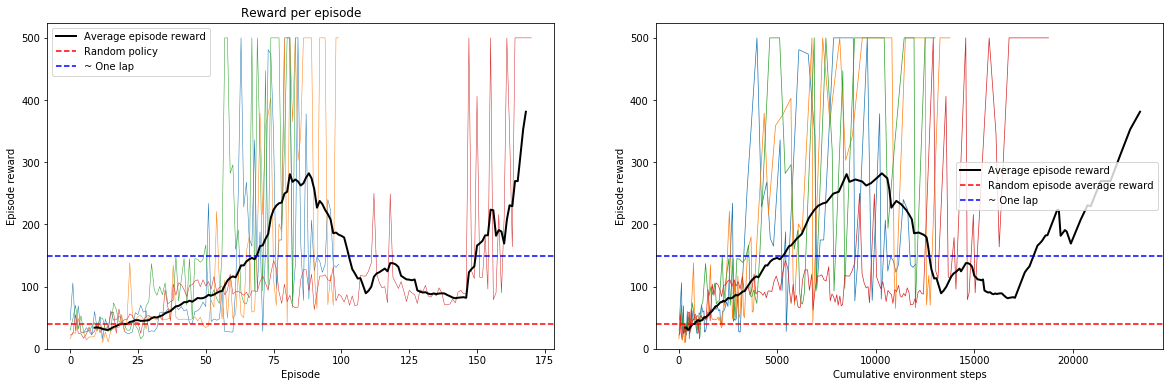

In [45]:
visualize.visualize_run("../records/real_pretrained_1/", real_car=True)

The car learns to drive in similar amount of steps as the non pretrained one. However, I had one run where I got really stuck on one bend.

The plots are not that great but my own subjective feeling is that the VAE still performed a bit better. For example, once the car made it halfway through the track it could quickly make a complete lap. I also think that the stability was better even though that is difficult to say from the plots.

I pretrained the VAE with about 10000 images taken from around the track but I think that more care could be put into collecting the dataset to actually make it more represtative. I for example lifted the car a lot so there are probably many fuzzy images from outside the car's domain. Leaning a represation for these wastes encoder capacity and can probably have an effect on the performance.

### Simulator

For reference, here are some results that I have from the simulator with the exactly same setup that I used for the real car.

We can see that even in the simulator there are still stability issues and in 50 episodes the policies don't converge. Performance in the simulator is higly dependent on the track. This can be seen as the different levels in the plots that correspond to bends on the track.

My current setup is optimized for the real car and I could do much better in the simulator with some tuning. For example the encoder is probably too small for the simulator or at least a larger encoder improves perofomance in the simulator but not on the real car.  In the simulator the track is longer and there is more variability in the data so probaly a smaller encoder does not cut it.

#### Critic loss not used to update the encoder

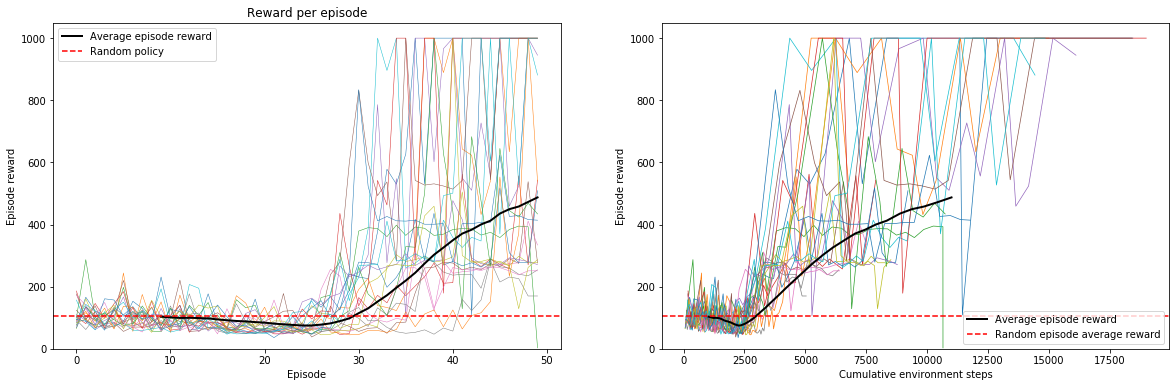

In [46]:
visualize.visualize_run("../records/sim_not_pretrained_no_critic_encoder_update/", episodes=50)

#### Pretrained VAE

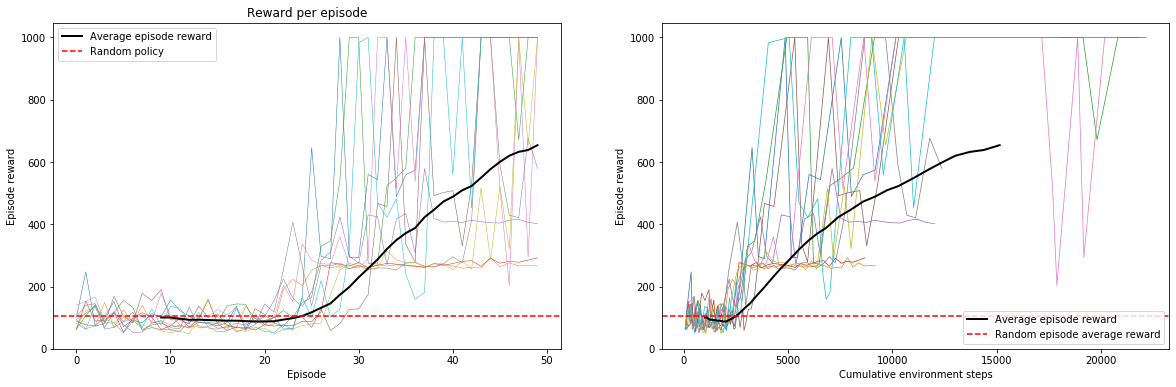

In [47]:
visualize.visualize_run("../records/sim_pretrained/", episodes=50)

#### Critic loss used to update encoder

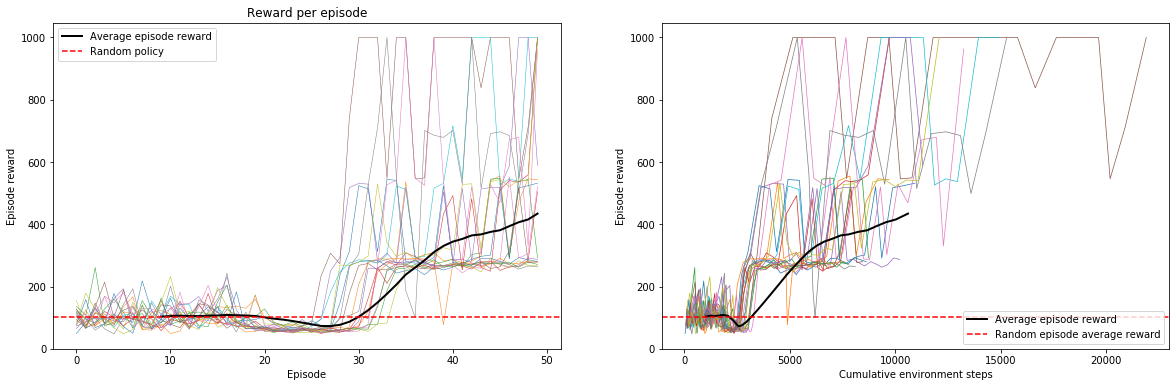

In [48]:
visualize.visualize_run("../records/sim_not_pretrained_critic_encoder_update/")